# Optimización de fotolitografía

**Autor**:  Luis Miguel Sánchez Brea

**Fecha**: 31/10/2021

**Objetivo**: Utilizar pyswarm con algún procedimiento de diffractio. optimización fotolitográfica

**Descripción**: 

- Como función objetivo ponemos el foco de una lente stándard. o una delta de dirac
- Ponemos los anillos iniciales como si fuera un axicón.
- optmizamos con pocos puntos, para que no sea demasiado lento.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import np, sp, plt
from diffractio import mm, um, nm, degrees

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.utils_math import nearest

from diffractio.utils_drawing import draw_several_fields

number of processors: 8
total memory        : 7.5 Gb
available memory    : 37 %
max frequency       : 4000 GHz


In [3]:

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

## Descripción de la intensidad

In [4]:
def generate_rectangle(parameters, t_mask, has_draw=False):
    
    p0,p1,p2,p3,p4=parameters
    
    x0 = t_mask.x
    y0 = t_mask.y
    wavelength = t_mask.wavelength
    
    t_mask.square(r0=(0,0), size=(p0,20), angle=0)
    
    t_rectangle = Scalar_mask_XY(x0,y0,wavelength)
    t_rectangle.square(r0=(p1,0), size=(p2,20), angle=0)
    
    t_mask.u=t_mask.u + t_rectangle.u
    
    t_rectangle.square(r0=(p3,0), size=(p4,20), angle=0)
    t_mask.u=t_mask.u + t_rectangle.u

    
    if has_draw:
        t_mask.draw()
    
    return t_mask

In [5]:
def propagate_intensity(parameters, t_mask, has_draw=False):
    
    
    t_mask=generate_rectangle(parameters, t_mask, has_draw=False)
    
    
    u2=t_mask.RS(z=distance,verbose=False)
    
    if has_draw:
        u2.draw(has_colorbar='vertical', logarithm=False)
    
    
    return u2.intensity()

## Funciones de coste

El número de dimensiones del problema corresponde con el número de transiciones de la red de Damman. El número de órdenes corresponde con los órdenes de difracción de la red.

## Optimization

In [6]:
def cost_function_2(intensity, intensity_desired):
    
    distance = np.sqrt(((intensity-intensity_desired)**2).mean())/intensity_desired.mean()
    
    return(distance)

In [7]:
def optimization_loop_2(parameters, t_mask, intensity_desired, has_draw=False):

    u_propagated = generate_rectangle(parameters, t_mask, has_draw=False)
    intensity=u_propagated.intensity()
    cost1 = cost_function_2(intensity, intensity_desired)
    return cost1

In [8]:
def opt_func_2(Parameters, t_mask, intensity_desired):
    num_particles = Parameters.shape[0]  # number of particles
    intensidad = [optimization_loop_2(Parameters[i,:],t_mask, intensity_desired) for i in range(num_particles)]
    return intensidad

### Otros parámetros a explorar:

In [9]:
def strehl_ratio(I_sample, I_ideal):
    return I_ideal/I_sample

In [10]:
def intensity_max(u, verbose=False):
    intensity_focus=u.intensity()
    intensity_max=intensity_focus.max()
    if verbose:
        print("I_max = {2.2f}".format(intensity_max))
    return intensity_max


In [11]:


def intensity_out(u, radius_out, size=0, mask=None, has_draw=False, verbose=False):
    if size>0:
        u3=u.cut_resample(x_limits=(-size/2,size/2),y_limits=(-size/2,size/2), new_field=True)
    else: 
        u3=u
        size=u.x[-1]
    
    if has_draw:
        u3.draw(logarithm=True)        
        u3.draw_profile([-size,0], [size,0]);

    intensity_focus=u3.intensity()
    intensity_max=intensity_focus.max()        
        
    i_x_max,_,_=nearest(u3.x,0)
    i_y_max,_,_=nearest(u3.y,0)        

    #forma sencilla
    I_optimal=np.zeros_like(u3.u, dtype=float)
    I_optimal[i_y_max,i_x_max]=intensity_max
    mask_size = intensity_focus.size
    
    if mask is None:
        #forma más elaborada
        mask=Scalar_mask_XY(u3.x,u3.y,u3.wavelength)
        mask.circle(r0=(0,0), radius=radius_out)
        mask.inverse_amplitude()
        
    if has_draw:
        mask.draw()
        plt.title('mask')

    mask_size=mask.u.sum()
    error=np.real((mask.u*(intensity_focus-I_optimal)).sum()/mask_size)
    
    if verbose:
        print("error = {:2.2f}".format(error))
    
    return error, mask



## Create example

In [12]:
num_pixels=128
distance=20*um
wavelength=1
diameter=20*um
x0=np.linspace(-diameter/2,diameter/2,num_pixels)
y0=np.linspace(-diameter/2,diameter/2,num_pixels)

t_mask=Scalar_mask_XY(x0,y0,wavelength)


### Rectangle


I_max = 1400 con la lente de Fresnel. La lente tiene 20 anillos.


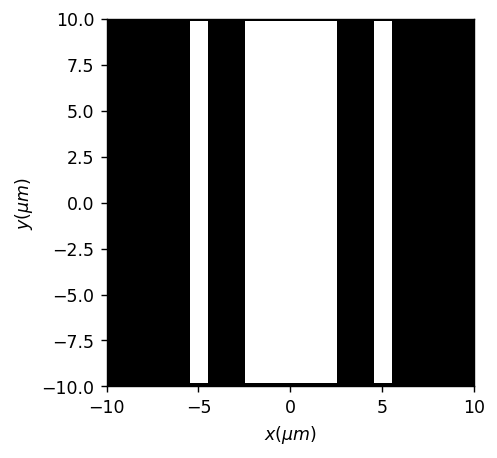

In [13]:
t_mask0=Scalar_mask_XY(x0,y0,wavelength)
t_mask0=generate_rectangle(parameters=(5,-5, 1,5,1), t_mask=t_mask, has_draw=True)

In [14]:
u_fresnel=t_mask0.RS(z=distance, verbose=True)

Good result: factor 7.49


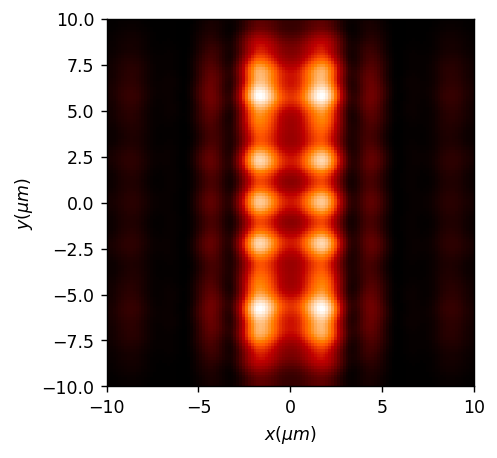

In [15]:
u_fresnel.draw(logarithm=True);

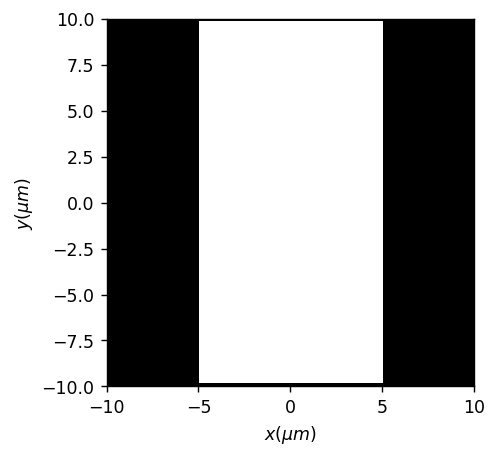

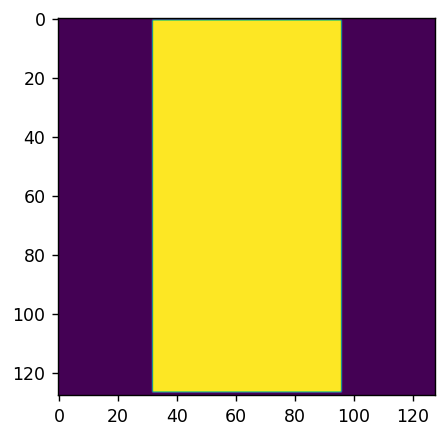

In [16]:
t_mask.square(r0=(0,0), size=(10,20),angle=0)
t_mask.draw()
intensity_target=np.abs(t_mask.u)**2
plt.figure()
plt.imshow(intensity_target)

In [17]:
u_fresnel=t_mask.RS(z=distance, verbose=True)

Good result: factor 7.49


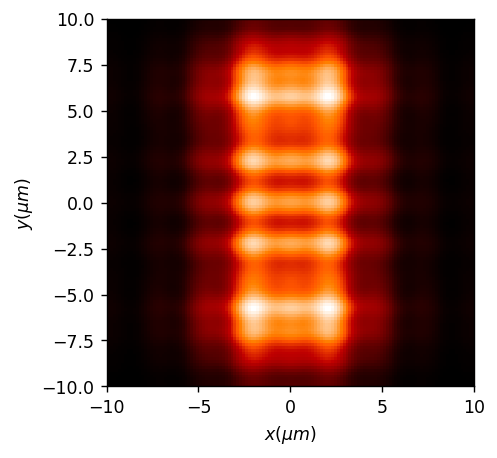

In [18]:
u_fresnel.draw(logarithm=True);

In [19]:
intensity_fresnel=u_fresnel.intensity()
intensity_fresnel_max=intensity_fresnel.max()

### Ejecuciones de costes

In [20]:
cost_value2=cost_function_2(intensity_target, intensity_fresnel)

print(cost_value2)

0.7567672394375069


In [21]:
cost_value2=cost_function_2(intensity_target, intensity_fresnel)

print( cost_value2)

0.7567672394375069


# Algorithm

0https://pythonhosted.org/pyswarm/

Utilizamos la función GlobalBestPSO de PySwarms para optimizar la función, cuyos argumentos son los siguientes:

- n_particles: # de partículas que el algoritmo utiliza para alcanzar el mínimo.
- dimensions: Las dimensiones corresponde con las trasiciones de nuestra red.
- options: 
   * c1 : float
      cognitive parameter
   * c2 : float
        social parameter
   * w : float
        inertia parameter 
   * 'omega : flaot
       velocity factor
       
- bounds: Restricciones mínima y máxima de las transiciones de la red



In [22]:
num_parameters= 5 #pares
num_iters= 150# suelen ser más
num_particles = 100 # suelen ser 
radius_max = x0[-1]

In [57]:
min_bound = (0,-radius_max,.15,5,.15)
max_bound = (10, -5, radius_max, radius_max,radius_max )
bounds = (min_bound, max_bound)

omega_0 = np.linspace(0.9,0.25,num_parameters)
omega_0=0.9

t_mask=Scalar_mask_XY(x0,y0,wavelength)

In [58]:

options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9, 'omega': omega_0}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=num_parameters, options=options, bounds=bounds)

In [59]:
%%time



cost, parameters_final = optimizer.optimize(opt_func_2, iters=num_iters,  t_mask=t_mask, intensity_desired=intensity_target)

2021-11-01 06:16:18,771 - pyswarms.single.global_best - INFO - Optimize for 150 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9, 'omega': 0.9}
pyswarms.single.global_best: 100%|██████████|150/150, best_cost=0.436
2021-11-01 06:16:27,327 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4364357804719848, best pos: [ 9.98843943 -7.13025822  0.4702915   9.23850276  0.53108638]


CPU times: user 8.57 s, sys: 56.4 ms, total: 8.63 s
Wall time: 8.56 s


In [60]:
parameters_final


array([ 9.98843943, -7.13025822,  0.4702915 ,  9.23850276,  0.53108638])

<AxesSubplot:title={'center':'Cost History'}, xlabel='Iterations', ylabel='Cost'>

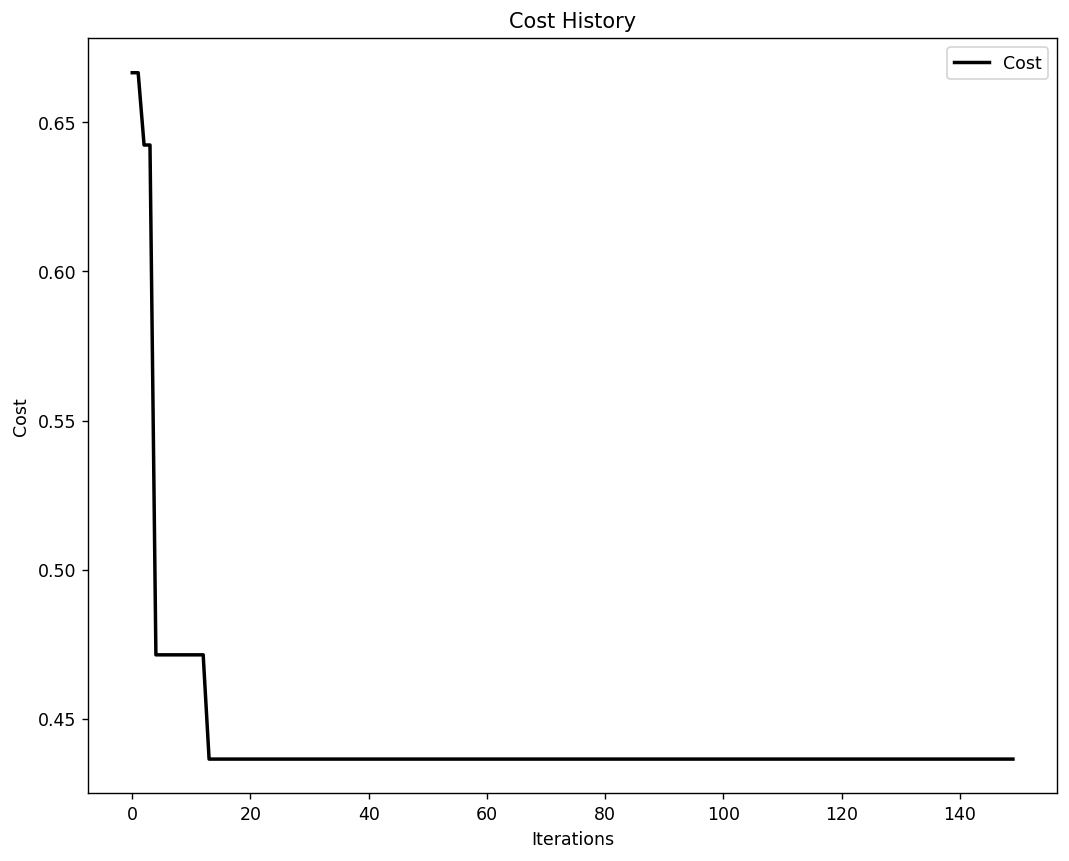

In [61]:
plot_cost_history(cost_history=optimizer.cost_history)

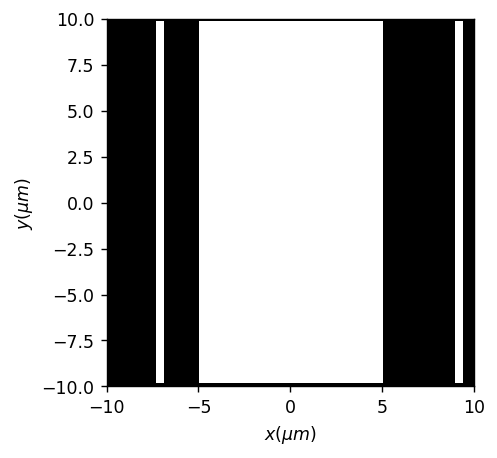

In [62]:
t_mask=Scalar_mask_XY(x0,y0,wavelength)
t_mask=generate_rectangle(parameters=parameters_final, t_mask=t_mask, has_draw=True)

In [63]:
parameters_final

array([ 9.98843943, -7.13025822,  0.4702915 ,  9.23850276,  0.53108638])

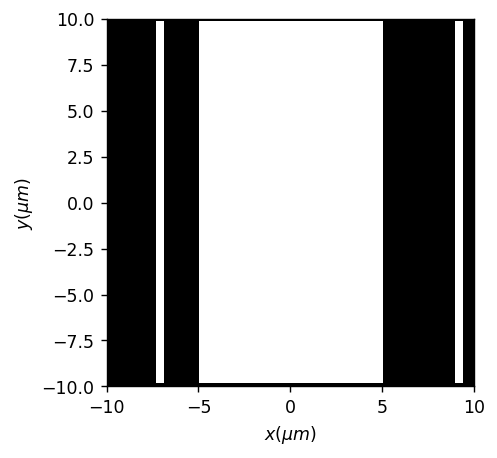

In [64]:
t_final=generate_rectangle(parameters_final, t_mask, has_draw=True)


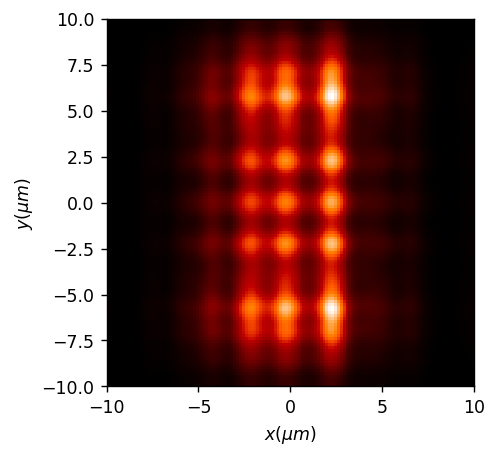

In [65]:
u_final=t_final.RS(distance)
u_final.draw()
intensity_final=u_final.intensity()

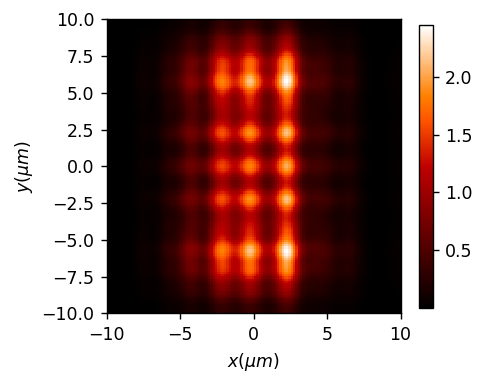

In [66]:
u_final=propagate_intensity(parameters_final, t_mask, has_draw=True)

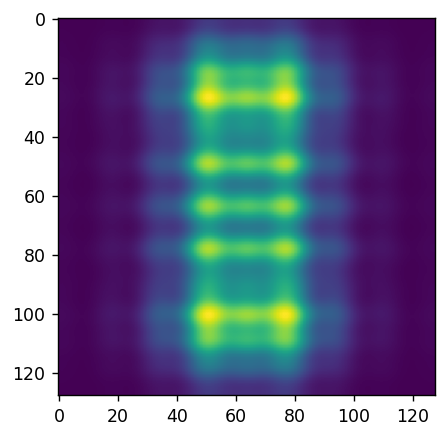

In [67]:
plt.imshow(intensity_fresnel)

In [68]:
cost_value2=cost_function_2(intensity_final, intensity_target)

print(cost_value2)

0.7525544058941701


In [69]:
cost_value2=cost_function_2(intensity_fresnel, intensity_target)

print( cost_value2)

0.6885884899489474


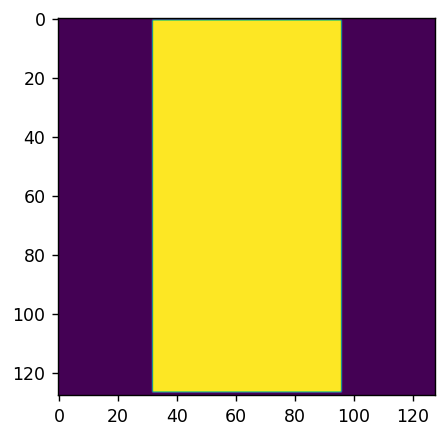

In [70]:
plt.imshow(intensity_target)

## Conclusiones
- dradius_max

## Tareas
- Aprender bien PSO y calcular parámetros. ¿cuál es la velocidad?
- Poner límites y evitar transiciones.
- se podrían poner límites de fabricabilidad, es decir si la distancia entre 2 puntos es pequeña, separarla